Коэффициент демпфирования: 0.6901
Собственная частота: 115.92 рад/с
Ранг матрицы управляемости: 2
Желаемые полюсы: -80.00+83.90j и -80.00-83.90j
Коэффициенты регулятора: K = [[  15.4        1266.33964085]]

Результаты:
Установившееся значение: 0.0037
Перерегулирование: 5.01%
Время регулирования: 0.0380 с


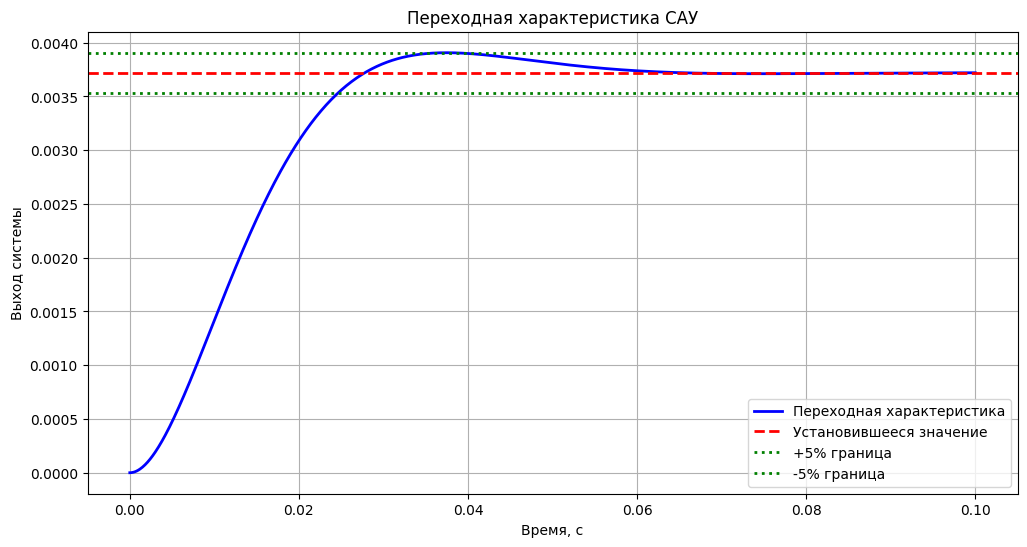

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl

# Задание параметров объекта управления и требуемых характеристик:
# W(s) = 10/((s+1)(s+5))
# Требуются: время регулирования t_ureg = 0.05 с и перерегулирование 5%.
# Управляющее воздействие задаётся как uy = 5.

k = 10             # коэффициент усиления
t_ureg = 0.05      # требуемое время регулирования, с
pere_reg = 5       # требуемое перерегулирование, %
uy = 5             # величина управляющего воздействия

# Расчёт коэффициента демпфирования по методике Кочеткова:
#   ξ = -ln(σ/100) / sqrt(π² + (ln(σ/100))²)
xi = -np.log(pere_reg/100.0) / np.sqrt(np.pi**2 + np.log(pere_reg/100.0)**2)
print(f"Коэффициент демпфирования: {xi:.4f}")

# Расчёт собственной (натуральной) частоты по формуле лабораторной работы №3:
#   ω_n = 4/(ξ * t_ureg)
omega_n = 4 / (xi * t_ureg)
print(f"Собственная частота: {omega_n:.2f} рад/с")

# Для W(s)=10/(s+1)(s+5)
A = np.array([[-1, 0],
              [ 1, -5]])
B = np.array([[10],
              [ 0]])
C = np.array([[0, 1]])
D = np.array([[0]])

sys = ctrl.ss(A, B, C, D)

# Проверка полной управляемости объекта с помощью матрицы управляемости:
ctrb_matrix = ctrl.ctrb(A, B)
rank_ctrb = np.linalg.matrix_rank(ctrb_matrix)
print(f"Ранг матрицы управляемости: {rank_ctrb}")

# Постановка задачи модального управления.
# Требуется разместить определяющую комплексно-сопряжённую пару полюсов замкнутой системы:
#   s₁,₂ = -ξ·ω_n ± j·ω_n·sqrt(1-ξ²)

s1 = -xi * omega_n + 1j * omega_n * np.sqrt(1 - xi**2)
s2 = -xi * omega_n - 1j * omega_n * np.sqrt(1 - xi**2)
desired_poles = [s1, s2]
print(f"Желаемые полюсы: {s1:.2f} и {s2:.2f}")

# Синтез регулятора методом размещения полюсов:
K = ctrl.place(A, B, desired_poles)
print(f"Коэффициенты регулятора: K = {K}")

# Формирование замкнутой системы с обратной связью.
# Замкнутая система описывается матрицей:
#   A_closed = A - B*K
# Для учёта величины управляющего воздействия (uy) корректно задаём вход:
#   B_closed = B * uy

A_closed = A - B @ K  # @ обеспечивает матричное умножение
B_closed = B * uy
closed_loop = ctrl.ss(A_closed, B_closed, C, D)

# Симуляция переходного процесса (отклика системы на единичный скачок)

t = np.linspace(0, 0.1, 1000)
t, y = ctrl.step_response(closed_loop, T=t)

# Расчёт установившегося значения, перерегулирования и времени регулирования:
steady_state = y[-1]
max_value = np.max(y)
actual_overshoot = (max_value - steady_state) / abs(steady_state) * 100

# Расчет времени регулирования по 5%-критерию:
# Находим последний момент времени, когда отклонение от установившегося значения превышает 5%
tol = 0.05 * abs(steady_state)
idx = np.where(np.abs(y - steady_state) > tol)[0]
if len(idx) > 0 and idx[-1] < len(t) - 1:
    settling_time = t[idx[-1] + 1]
else:
    settling_time = t[-1]

print("\nРезультаты:")
print(f"Установившееся значение: {steady_state:.4f}")
print(f"Перерегулирование: {actual_overshoot:.2f}%")
print(f"Время регулирования: {settling_time:.4f} с")

# Построение графика переходной характеристики:

plt.figure(figsize=(12, 6))
plt.plot(t, y, 'b-', linewidth=2, label='Переходная характеристика')
plt.axhline(steady_state, color='r', linestyle='--', linewidth=2, label='Установившееся значение')
plt.axhline(1.05 * steady_state, color='g', linestyle=':', linewidth=2, label='+5% граница')
plt.axhline(0.95 * steady_state, color='g', linestyle=':', linewidth=2, label='-5% граница')
plt.xlabel('Время, с')
plt.ylabel('Выход системы')
plt.title('Переходная характеристика САУ')
plt.legend()
plt.grid(True)
plt.show()
